<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/OU_process/Models/standard_pinn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
from torch.nn import ReLU
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.integrate as integrate
import scipy.special as special
import scipy.ndimage as ndimage

In [19]:
#radius of the ball
radius = 2

#parameters of the OU process
theta = 1
sigma = 0.5
lambda_ = theta/sigma**2

#definition of the true solution for comparison

def true_solution(x, y, theta=theta, lambda_=lambda_):
    rho = np.sqrt(x**2 + y**2)
    integral, _ = integrate.quad(lambda t : np.exp(lambda_ * t**2) * special.gammainc(1, lambda_ * t**2) / t, rho, radius)
    return integral/theta

#make the true_solution compatible with numpy arrays
true_solution_vectorized = np.vectorize(true_solution)

#plotting the function (inspiration taken from https://stackoverflow.com/questions/27606079)
n_points = 400
tt = np.linspace(-1, 1, n_points) * radius
xx, yy = np.meshgrid(tt, tt)  # create unit square grid

xx, yy = np.where(xx**2 + yy**2 <= radius**2, xx, 0), np.where(xx**2 + yy**2 <= radius**2 , yy, 0) #(https://stackoverflow.com/questions/15733530/)
zz = true_solution_vectorized(xx,yy)

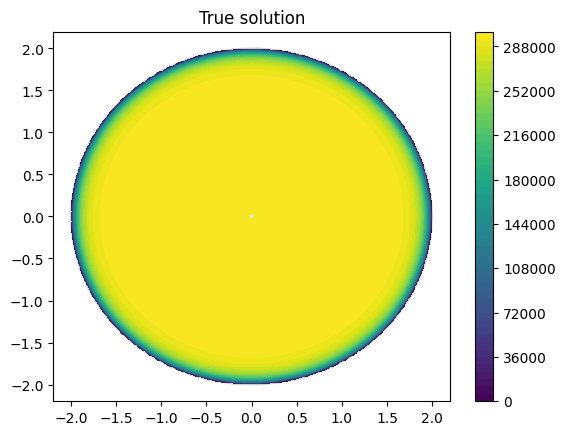

In [21]:
#circle
a = np.linspace(0, 2*np.pi, 50)
cx,cy = np.cos(a) * radius , np.sin(a)*radius

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)

contour = ax.contourf(xx, yy, zz, levels=50)  # 50 contour levels
ax.set_title("True solution")
cb = fig.colorbar(contour, ax=ax)

As we can see, the true solution blows up extremely fast away from the boundary, and is thus likely to be hard to learn.

In [22]:
#define ReLU^k activation

class RePU(nn.Module):

    def __init__(self, power = 2):
        super(RePU, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.pow(torch.relu(x), self.power)


In [95]:
iter = 0
n_iter = 5000
width = 1000
losses = []

class StandardPINN(nn.Module):

    def __init__(self, power = 2, width = width):
        super().__init__()

        self.layers = torch.nn.Sequential(torch.nn.Linear(2, width),
                                          RePU(power),
                                          torch.nn.Linear(width, 1))

    def forward(self, x):
        return self.layers(x)

def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    """
    This function calculates the derivative of the model at x_f
    """
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs = torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

def u_function(model: StandardPINN, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the model on the input x
    """
    model_input = torch.stack((x, y), axis = 1)
    return model(model_input)


def residual(model, x_f, y_f):
    u = u_function(model, x_f, y_f)
    u_x = derivative(u, x_f, order=1)
    u_y = derivative(u, y_f, order=1)
    u_xx = derivative(u, x_f, order=2)
    u_yy = derivative(u, y_f, order=2)
    res = - theta * (x_f * u_x + y_f * u_y) \
        + sigma**2 * (u_xx + u_yy)/2 \
        + 1
    return res

def loss_function(model: StandardPINN, x_c: torch.Tensor, y_c: torch.Tensor, x_b: torch.Tensor, y_b: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the physics governing the model on the input x_f
    """
    domain_residual = residual(model, x_c, y_c).pow(2).mean() #residual
    boundary_residual = (u_function(model, x_b, y_b)).pow(2).mean() #boundary
    return domain_residual + boundary_residual

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain=10)
        m.bias.data.fill_(10)


def closure(model: StandardPINN, optimizer, X_c_train: torch.Tensor, X_b_train:torch.Tensor) -> torch.Tensor:
    """
    In order to use the LBFGS optimizer, we need to define a closure function. This function is called by the optimizer
    and the optimizer contains the inner loop for the optimization and it continues until the tolerance is met.
    """
    x_c = X_c_train[:, 0]
    y_c = X_c_train[:, 1]
    x_b = X_b_train[:, 0]
    y_b = X_b_train[:, 1]
    optimizer.zero_grad()
    loss = loss_function(model, x_c, y_c, x_b, y_b)
    loss.backward()
    global iter
    iter += 1
    print(f" iteration: {iter}  loss: {loss.item()}")
    losses.append(loss.item())
    return loss

def train(model, X_c_train, X_b_train, n_iter = n_iter):
    # Initialize the optimizer
    # optimizer = torch.optim.LBFGS(model.parameters(),
    #                                 lr=1,
    #                                 #max_iter=50000,
    #                                 #max_eval=50000,
    #                                 #history_size=50,
    #                                 tolerance_grad=0,
    #                                 tolerance_change=0,
    #                                 line_search_fn="strong_wolfe")

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # the optimizer.step requires the closure function to be a callable function without inputs
    # therefore we need to define a partial function and pass it to the optimizer
    closure_fn = partial(closure, model, optimizer, X_c_train, X_b_train)

    for i in range(n_iter):
        optimizer.step(closure_fn)

In [96]:
radius = 2 #radius of the circle
theta = 1
sigma = 0.5 #parameters of the OU process

N_c = 250 #number of points in the domain
N_b = 2 * N_c #number of points on the boundary

#definition of X_b_train : N_b points on the boundary
t = np.linspace(0, 2*np.pi, N_b, endpoint=False)
x_b = radius * np.cos(t)
y_b = radius * np.sin(t)
X_b_train = np.vstack( (x_b, y_b) )

#shuffling X_b_train
index = np.arange(0, N_b)
np.random.shuffle(index)
X_b_train = X_b_train[:, index]

#definition of X_c_train : N_c points in the disk
t = np.random.uniform(0,2*np.pi, N_c)
rho = np.random.uniform(0,radius, N_c) ** 0.5 #uniform distribution on the disk
x_c = rho * np.cos(t)
y_c = rho * np.sin(t)
X_c_train = np.vstack( (x_c, y_c) )

#shuffling X_c_train
index = np.arange(0, N_c)
np.random.shuffle(index)
X_c_train = X_c_train[:,index]

In [97]:
#model instantiation
model = StandardPINN()
model.apply(init_weights)

# Training
losses = []
X_b_train = torch.from_numpy(X_b_train).requires_grad_(True).float()
X_c_train = torch.from_numpy(X_c_train).requires_grad_(True).float()

model.train()
train(model, X_c_train, X_b_train)

 iteration: 1  loss: 4197217.0
 iteration: 2  loss: 3710233.5
 iteration: 3  loss: 3254388.25
 iteration: 4  loss: 2830131.25
 iteration: 5  loss: 2437801.5
 iteration: 6  loss: 2077588.375
 iteration: 7  loss: 1749519.125
 iteration: 8  loss: 1453429.625
 iteration: 9  loss: 1188953.875
 iteration: 10  loss: 955498.6875
 iteration: 11  loss: 752232.625
 iteration: 12  loss: 578074.125
 iteration: 13  loss: 431678.46875
 iteration: 14  loss: 311444.71875
 iteration: 15  loss: 215521.140625
 iteration: 16  loss: 141825.453125
 iteration: 17  loss: 88073.09375
 iteration: 18  loss: 51819.26953125
 iteration: 19  loss: 30511.8515625
 iteration: 20  loss: 21550.98046875
 iteration: 21  loss: 22357.640625
 iteration: 22  loss: 30442.59765625
 iteration: 23  loss: 43473.5859375
 iteration: 24  loss: 59336.4609375
 iteration: 25  loss: 76184.625
 iteration: 26  loss: 92474.9296875
 iteration: 27  loss: 106988.078125
 iteration: 28  loss: 118832.453125
 iteration: 29  loss: 127432.359375
 iter

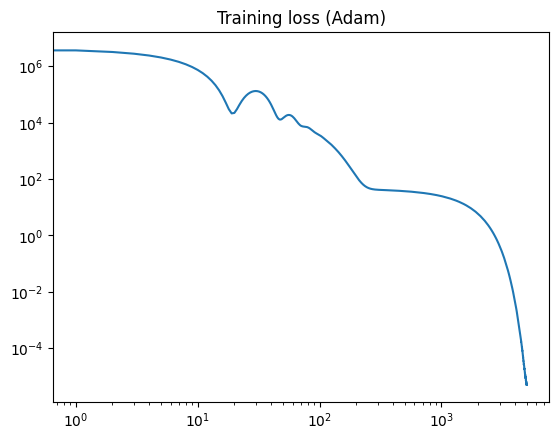

In [98]:
plt.loglog(losses)
plt.title('Training loss (Adam)')
plt.show()

In [99]:
# save the model
torch.save(model.state_dict(), 'standard_pinn_adam.pt')

<ipython-input-101-38570322be38>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('standard_pinn_adam.pt'))


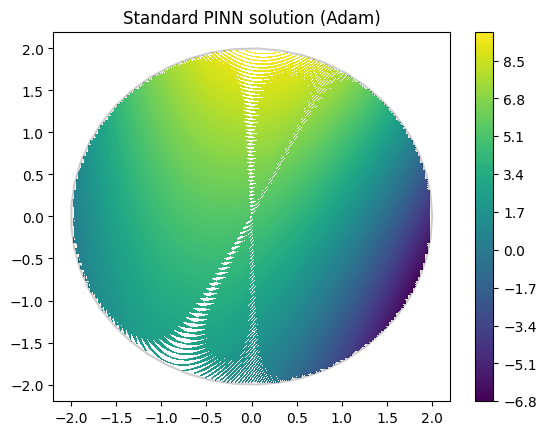

In [101]:
#load the model
model = StandardPINN()
model.load_state_dict(\
torch.load('standard_pinn_adam.pt'))

#evaluate the model on a uniform grid
n_points = 150
tt = np.linspace(-1, 1, n_points) * radius
xx, yy = np.meshgrid(tt, tt)  # create unit square grid
xx, yy = np.where(xx**2 + yy**2 <= radius**2, xx, 0), np.where(xx**2 + yy**2 <= radius**2 , yy, 0) #(https://stackoverflow.com/questions/15733530/)
zz_true = true_solution_vectorized(xx,yy)

input = torch.from_numpy(np.vstack((xx.ravel(),yy.ravel())).T).float()#.requires_grad_(False)
learned_sol = model(input)

#plot
learned_sol_np = learned_sol.detach().numpy().reshape(xx.shape)
#learned_sol_smooth = ndimage.gaussian_filter(learned_sol_np, sigma=0.1, order=0) #smoothing for visualization

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)
contour = ax.contourf(xx, yy, learned_sol_np, levels=200)
ax.set_title('Standard PINN solution (Adam)')
cb = fig.colorbar(contour, ax=ax)